# Multiclass LDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from numpy.linalg import inv,det,multi_dot
from itertools import combinations

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

In [8]:
class LDA:    
    def __init__(self):
        self.x=None
        self.y=None
        self.cov_mat = None
        self.weights = None
        self.bias = None
        
    def Discriminant_function(self,x,mean,cov_mat,class_prob):
        cov1=inv(cov_mat)        
        DF =np.dot(np.dot(mean.T,cov1),x) -0.5*multi_dot([mean.T,cov1,mean]) + np.log(class_prob)        
        return(DF)
    
    def mean_correlated_matrix(self,x,u):
        #perform(x-u)
        meaned = x.copy().T
        r,c=x.shape 
        for i in range(c): 
            # iterate over column
            meaned[i] = meaned[i] - u[i]         
        return meaned.T 
    
    def covarience_matrix(self,a):
        r,c=a.shape
        s=(1/(r-1))*np.dot(a.T,a)
        return s

    def LDA_Train(self,x,y):        
        self.x = x
        self.y = y
        r,c = x.shape
        K = list(np.unique(y)) 
        print(" ")
        print(" ")
        print(".......Total Number Of Classes present in Data....")
        print(K)
        self.Class = K        
        Xk= { }
        class_prob= { } 
        mean_vector= { }
        Xk_u= { }
        cov_mat= { }
        L = { }
        cov_merged=0
        x["target"] = y       # creating one extra column same as y          
                              #splitting X rows with respect to class
        for i in range(len(K)):            
            Xk[i]=np.array(x[x["target"]==K[i]].drop("target",axis=1))
                         #deleting extra column from y                 
            class_prob[i]=len(Xk[i])/r       
            mean_vector[i] =np.mean(Xk[i],axis=0)            
            Xk_u[i]= self.mean_correlated_matrix ( Xk[i],mean_vector[i] )
            L[i]=len(Xk[i])
            cov_mat[i]=self.covarience_matrix(Xk_u[i])            
            cov_merged=cov_merged+(((L[i]-1)*cov_mat[i])/(r-2))    
        
        
        cov_inv=inv(cov_merged)      
        self.class_prob=class_prob
        self.cov_mat=cov_mat
        self.mean=mean_vector        
        self.weights={ }
        self.bias={ }
                                  #for hyperplane parameters
        m=[*range(len(K))]
        p=list(combinations(m, 2))
        print(p)
        for i in range(len(p)):           
            self.weights[i]=(np.dot(cov_inv,(mean_vector[p[i][0]]-mean_vector[p[i][1]])))
            self.bias[i]=((-0.5)* multi_dot([mean_vector[p[i][0]].T,cov_inv,mean_vector[p[i][0]]])
                          +(0.5)* multi_dot([mean_vector[p[i][1]].T,cov_inv,mean_vector[p[i][1]]]) 
                          + np.log(class_prob[p[i][0]]/class_prob[p[i][1]]))
        print(" ")
        print('Parameters for hyperplane are-->')
        print(self.weights)
        print(" ")
        print("bais ")
        print(self.bias)
        
                                         
         
    def LDA_Test(self,x,y):        
        y_pred = [ ]
        g={ } 
        x=np.array(x)
        #created a dictonary which have(xtest:)as index and deiscrimant calculated value for each class as its keys
        for r in range(len(x)):
            g[r]={}
            for i in range(len(self.Class)):                
                g[r][i] = self.Discriminant_function(x[r], self.mean[i],self.cov_mat[i],self.class_prob[i])                
                
            #finding  max value for xtest written its index (calss)
            key_max = max(g[r].keys(), key=(lambda k: g[r][k]))            
            y_pred.append(self.Class[key_max])    
        
        cm1=self.confusion_mat(y,y_pred)
        self.performance(cm1)        
        print(" ")
        print("confusion_matrix --------- ")
        print(cm1)
        self.plot_decison_boundary(x,y)
        
        
        
    def plot_decison_boundary(self,x_test,y_test):
        r,c = x_test.shape
        if(c<3):           
            #  2D hyperplane plotting
            x=x_test[:,0]
            for i in range(len(self.bias)):
                y_cal=-(self.bias[i]+ x * self.weights[i][0])/self.weights[i][1]
                plt.plot(x,y_cal)
            C=['red' if l==1 else 'blue' for l in y_test]
            plt.scatter(x_test[:,[0]], x_test[:,[1]], color= C ,label="Actual data")
            plt.xlabel('x_1',fontsize = 10)
            plt.ylabel('x_2',fontsize = 10)
            plt.legend(loc='best')
            plt.show()
        else:
            # 3D hyperplane plotting
            fig=plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection = '3d')
            C=[ ]
            for i in y_test:
                if i==-1:
                    C.append('blue')
                elif i==0:
                    C.append('red')
                else: 
                    C.append('green') 
                    
            x1=np.reshape(x_test[:,0], (r, 1))            
            x2=np.reshape(x_test[:,1], (r, 1)) 
            tmp = np.linspace(-6,6,3)
            for i in range(len(self.bias)):
                x1,x2 = np.meshgrid(tmp,tmp)
                z = lambda x1,x2: -(self.bias[i]+(x1*self.weights[i][0])+(x2*self.weights[i][1]))/self.weights[i][2]
                ax.plot_surface(x1, x2, z(x1, x2))  
                    
            
            ax.scatter3D(x_test[:,[0]], x_test[:,[1]], x_test[:,[2]], color= C ,label="Actual data")
            ax.set_xlabel('X1',fontsize = 10)
            ax.set_ylabel('X2',fontsize = 10)
            ax.set_zlabel('X3',fontsize = 10)
            plt.legend(loc='best')
            plt.show()
        
        
        

    def confusion_mat(self,y_test,y_pred):        
        cm = confusion_matrix(y_test,y_pred)
        return cm
        
    def performance(self,cm):
        r,c=cm.shape
        if(r==2):
            tp = cm[0][0]
            tn = cm[1][1]
            fp = cm[0][1]
            fn = cm[1][0]            
            
        elif(r==3):
            tp = cm[0][0]
            tn = cm[1][1]+cm[1][2]+cm[2][1]+cm[2][2]
            fp = cm[0][1]+cm[0][2]
            fn = cm[1][0]+cm[2][0]
        else:
            print("Error")
            
        accuracy=(tp+tn)/(tp+tn+fp+fn)
        sn = tp/(tp+fn)
        sp = tn/(tn+fp)
        pr = tp/(tp+fp)
        fm = 2*(pr*sn)/(pr+sn)
        print(" ")
        print("Performance of model")
        print(f"Accuracy is {accuracy}")
        print(f"Sensitivity is {sn}")
        print(f"Specificity is {sp}")
        print(f"Precission is {pr}")
        print(f"F_measur is {fm}")
        
    

In [5]:
def holdout_cross_validation(data):
    r,c=data.shape
    x = data.iloc[:,range(c-1)]
    y = data.iloc[:,c-1]
    for i in range(1):
        X_train,X_test,Y_train,Y_test = train_test_split(x,y,test_size=0.3) #creating train & test  using random  permutation        
        model = LDA()
        model.LDA_Train(X_train,Y_train)
        accuracy = model.LDA_Test(X_test,Y_test)                                 #passing training data & test data to LDA func
        
    

In [6]:
d1=pd.read_csv('data1.csv',header=None)
d1

,0,1,2,3
0,0.76038,1.718800,1.450700,-1
1,2.59350,0.052128,-1.252200,-1
2,-3.19450,-1.602100,0.030235,-1
3,1.21930,-0.172090,0.121620,-1
4,0.45080,0.717660,0.660560,-1
...,...,...,...,...
195,6.70320,-1.105100,3.142400,1
196,4.59740,-2.462100,1.490500,1
197,7.85930,-2.235500,1.846800,1
198,6.83340,1.317400,4.751300,1


 
 
.......Total Number Of Classes present in Data....
[-1, 1]
 
Parameters for hyperplane are-->
{0: array([-3.99197499,  3.07186867, -2.39845142])}
 
bais 
{0: 17.793505147716782}
 
Performance of model
Accuracy is 1.0
Sensitivity is 1.0
Specificity is 1.0
Precission is 1.0
F_measur is 1.0
 
confusion_matrix --------- 
[[35  0]
 [ 0 25]]


<IPython.core.display.Javascript object>


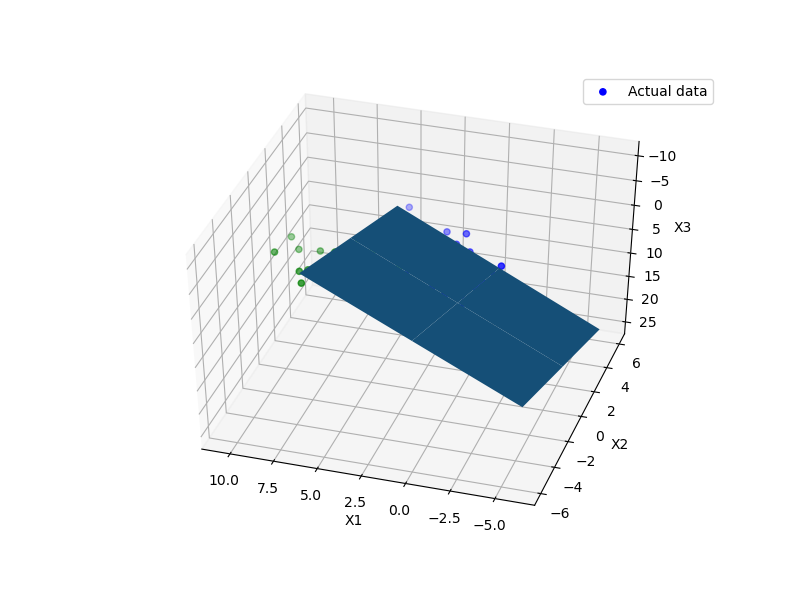

In [7]:
holdout_cross_validation(d1)

In [9]:
d4=pd.read_csv('data4.csv',header=None)
d4

,0,1,2,3
0,4.2051,-6.1167,1.43960,0
1,3.1240,-4.9395,0.48713,0
2,2.5558,-3.6797,2.38980,0
3,2.0951,-4.6226,-1.10800,0
4,1.1876,-4.6330,-0.83546,0
...,...,...,...,...
295,-5.5759,5.8074,-0.24647,1
296,-2.5420,3.4318,1.40050,1
297,-2.6997,5.0614,0.81236,1
298,-2.5853,5.6717,0.20096,1


 
 
.......Total Number Of Classes present in Data....
[-1, 0, 1]
[(0, 1), (0, 2), (1, 2)]
 
Parameters for hyperplane are-->
{0: array([-2.49199772,  3.27987002, -0.29168109]), 1: array([ 2.7017439 , -3.06347901, -0.05455604]), 2: array([ 5.19374162, -6.34334903,  0.23712505])}
 
bais 
{0: 11.617608691394764, 1: 12.51519481022438, 2: 0.8975861188296153}
 
Performance of model
Accuracy is 0.9888888888888889
Sensitivity is 0.9655172413793104
Specificity is 1.0
Precission is 1.0
F_measur is 0.9824561403508771
 
confusion_matrix --------- 
[[28  0  0]
 [ 0 33  0]
 [ 1  0 28]]


<IPython.core.display.Javascript object>


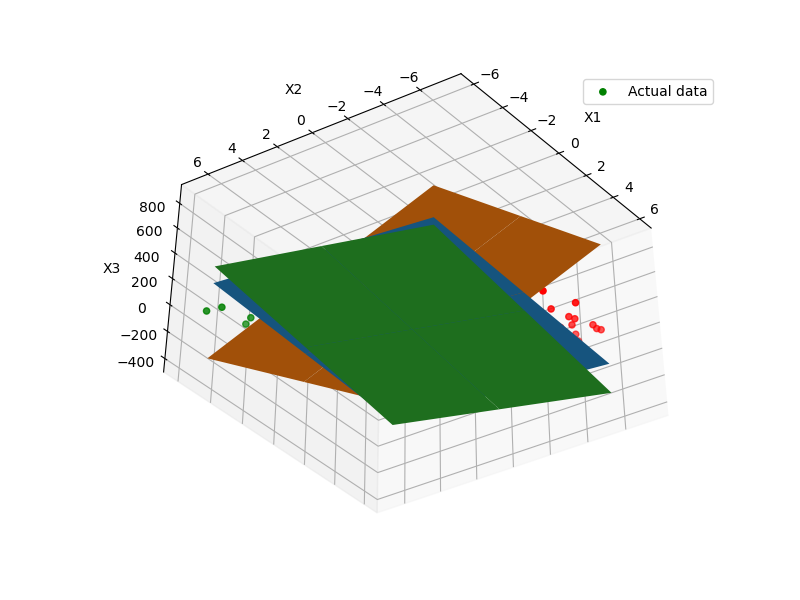

In [10]:
holdout_cross_validation(d4)